---
Author: Jeapo
title: Smartphone - Based Sensing of Pendulum Vibrations
---

**Instructor:** Mohammad Talebi-Kalaleh  
**Course:** Sensing Techniques and Data Analytics — Fall 2025

**Student ID:** `STUDENT_ID`  
**Name:** Your Name Here  
**Date:** YYYY-MM-DD  

**Tool Chains**: `Jupyter`->`Quarto`->`PDF`

## Assignment Outline

1. Setup & Imports  
2. Utility functions (data loading, peak detection, damping fit, stats)  
3. Part A — Short Pendulum (L ≈ 0.3 m)  
4. Part B — Long Pendulum (L ≈ 1.0 m)  
5. Part C — Nonlinear Regime (large angles)  
6. Part D — Noise discussion  
7. Figures & Data saving helpers  
8. Submission checklist

Each analysis part includes: data loading, visualization, statistical descriptors, period estimation, damping estimation, and discussion cells.


In [48]:
# Imports and plotting settings
import os
import glob
import numpy as np
import pandas as pd
import scipy.signal as signal
import scipy.optimize as optimize
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

# Ensure figures render in notebook
%matplotlib inline

# Reproducible plotting size policy
plt.rcParams['figure.figsize'] = (10,4)

# Paths (edit STUDENT_ID below)
STUDENT_ID = "STUDENT_ID"
BASE_DIR = f"."
DATA_DIR = os.path.join(BASE_DIR, 'Data')
FIG_DIR = os.path.join(BASE_DIR, 'Figures')



## Theoretical Model

### 2.1 Small-Angle Pendulum Period

For small angular displacements ($\theta \le 15^\circ$), the period of a simple pendulum is given by @eq-simple-pendulum:
$$
T_{n}=2\pi\sqrt{\frac{L}{g}}
$${#eq-simple-pendulum}

where:

  * $T\_n$ = oscillation period (seconds)
  * $L$ = pendulum length (meters)
  * $g$ = gravitational acceleration ($9.81, m/s^2$)

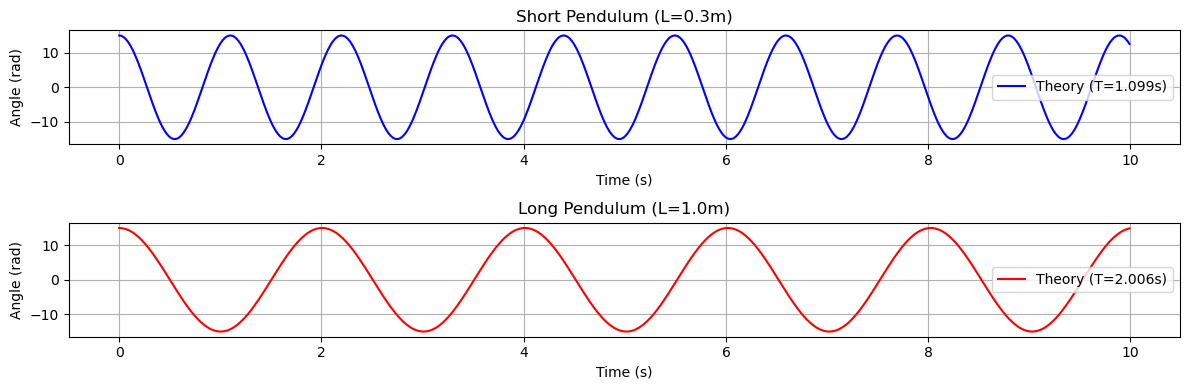

Theoretical periods:
Short pendulum: 1.099s
Long pendulum: 2.006s


In [49]:
# Generate theoretical data for comparison
def generate_theoretical_pendulum(L, t_max=10, dt=0.01, theta0=15, g=9.81):
    """Generate theoretical pendulum motion for small angles
    Args:
        L (float): pendulum length in meters
        t_max (float): simulation duration in seconds
        dt (float): time step in seconds
        theta0 (float): initial angle in radians
        g (float): gravitational acceleration (m/s^2)
    Returns:
        t, theta: time and angle arrays
    """
    t = np.arange(0, t_max, dt)
    omega = np.sqrt(g/L)  # natural frequency
    theta = theta0 * np.cos(omega * t)  # solution for small angles
    return t, theta

def theoretical_period(L, g=9.81):
    """Calculate theoretical period of a simple pendulum"""
    return 2 * np.pi * np.sqrt(L / g)

# Generate and plot theoretical data for both pendulum lengths
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4))

# Short pendulum
L_short = 0.3 # part A
t_short, theta_short = generate_theoretical_pendulum(L_short)
T_short = theoretical_period(L_short)
ax1.plot(t_short, theta_short, 'b-', label=f'Theory (T={T_short:.3f}s)')
ax1.set_title(f'Short Pendulum (L={L_short}m)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Angle (rad)')
ax1.grid(True)
ax1.legend()

# Long pendulum
L_long = 1.0 # part B
t_long, theta_long = generate_theoretical_pendulum(L_long)
T_long = theoretical_period(L_long)
ax2.plot(t_long, theta_long, 'r-', label=f'Theory (T={T_long:.3f}s)')
ax2.set_title(f'Long Pendulum (L={L_long}m)')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Angle (rad)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()
print(f'Theoretical periods:\nShort pendulum: {T_short:.3f}s\nLong pendulum: {T_long:.3f}s')

### 2.2 Damped Oscillation Model

The amplitude envelope of a damped pendulum follows exponential decay:
$$A(t)=A_{0} \exp(-\zeta\frac{2\pi}{T_{n}}t) \quad \tag{2}$$
where:

  * $A(t)$ = amplitude at time t
  * $A_0$ = initial amplitude
  * $\zeta$ = damping ratio (dimensionless)
  * $t$ = elapsed time (seconds)

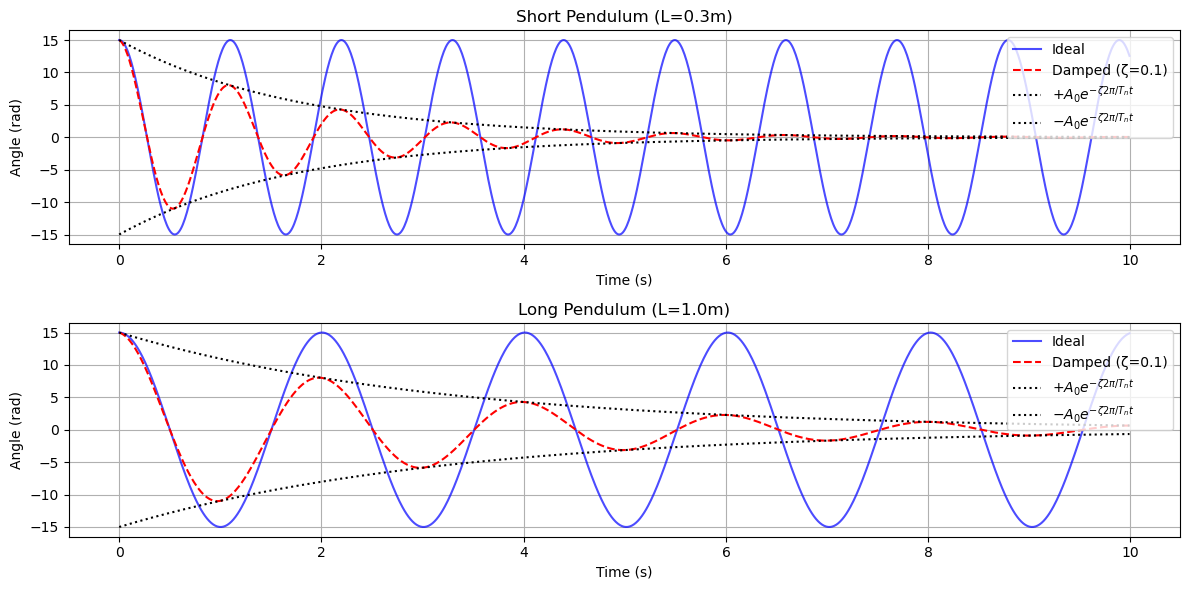

In [50]:
def generate_damped_pendulum(L, t_max=10, dt=0.01, theta0=15, zeta=0.1, g=9.81):
    """Generate damped pendulum motion
    Args:
        L (float): pendulum length in meters
        t_max (float): simulation duration in seconds
        dt (float): time step in seconds
        theta0 (float): initial angle in radians
        zeta (float): damping ratio (dimensionless)
        g (float): gravitational acceleration (m/s^2)
    Returns:
        t, theta: time and angle arrays
    """
    t = np.arange(0, t_max, dt)
    omega = np.sqrt(g/L)  # natural frequency
    # Damped solution
    theta = theta0 * np.exp(-zeta * omega * t) * np.cos(omega * t)
    return t, theta

# Plot comparison of ideal vs damped oscillation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Short pendulum comparison
t_short_damped, theta_short_damped = generate_damped_pendulum(L_short, zeta=0.1)
ax1.plot(t_short, theta_short, 'b-', label='Ideal', alpha=0.7)
ax1.plot(t_short_damped, theta_short_damped, 'r--', label='Damped (ζ=0.1)')
ax1.set_title(f'Short Pendulum (L={L_short}m)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Angle (rad)')
ax1.grid(True)

# Long pendulum comparison
t_long_damped, theta_long_damped = generate_damped_pendulum(L_long, zeta=0.1)
ax2.plot(t_long, theta_long, 'b-', label='Ideal', alpha=0.7)
ax2.plot(t_long_damped, theta_long_damped, 'r--', label='Damped (ζ=0.1)')
ax2.set_title(f'Long Pendulum (L={L_long}m)')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Angle (rad)')
ax2.grid(True)



# Add the +- A_0 exp(-zeta 2pi/T_n t) lines
for ax, t, theta0, Tn in [
    (ax1, t_short_damped, 15, theoretical_period(L_short)),
    (ax2, t_long_damped, 15, theoretical_period(L_long))
]:
    envelope = theta0 * np.exp(-0.1 * 2 * np.pi / Tn * t)
    ax.plot(t, envelope, 'k:', label=r'$+A_0 e^{-\zeta 2\pi/T_n t}$')
    ax.plot(t, -envelope, 'k:', label=r'$-A_0 e^{-\zeta 2\pi/T_n t}$')

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Data Preprocessing

In [51]:
import zipfile
import os
import glob
import pandas as pd

def extract_raw_data_from_zip_files(folder_path, experiment):
    """
    Finds all zip files in a folder, extracts 'Raw Data.csv' from each,
    and saves it with the zip file's name in a new 'extracted_data' folder.

    Args:
        folder_path (str): The path to the folder containing zip files.
    """
    # Define the name of the CSV file and the output directory
    csv_filename = "Raw Data.csv"
    output_dir = os.path.join(folder_path,"")

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")

    # Find all zip files in the specified folder
    zip_files = glob.glob(os.path.join(output_dir,experiment, "*.zip"))
    
    if not zip_files:
        print("No zip files found in the specified folder. Exiting.")
        return

    print(f"Found {len(zip_files)} zip files to process.")

    for zip_filepath in zip_files:
        try:
            with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                # Get the base name of the zip file without the extension
                base_name = os.path.splitext(os.path.basename(zip_filepath))[0]
                
                # Find the path to the CSV file inside the zip, accounting for nesting
                csv_member_path = None
                for member in zip_ref.namelist():
                    if member.endswith(csv_filename):
                        csv_member_path = member
                        break
                
                if not csv_member_path:
                    print(f"Warning: '{csv_filename}' not found in '{os.path.basename(zip_filepath)}'. Skipping.")
                    continue
                
                # Extract the file to a temporary location
                temp_extract_dir = os.path.join(output_dir, base_name)
                zip_ref.extract(csv_member_path, temp_extract_dir)
                
                # The extracted file's path
                extracted_file_path = os.path.join(temp_extract_dir, csv_member_path)

                # Define the new filename and path
                new_csv_filename = f"{base_name}.csv"
                new_csv_path = os.path.join(output_dir, new_csv_filename)
                
                # Move and rename the extracted file
                os.rename(extracted_file_path, new_csv_path)

                # Clean up the temporary directory structure
                os.rmdir(os.path.dirname(extracted_file_path))

                print(f"Successfully extracted and renamed '{os.path.basename(zip_filepath)}' to '{new_csv_filename}'.")

        except (zipfile.BadZipFile, FileNotFoundError) as e:
            print(f"Error processing '{os.path.basename(zip_filepath)}': {e}")
        except Exception as e:
            print(f"An unexpected error occurred with '{os.path.basename(zip_filepath)}': {e}")

if __name__ == "__main__" and False:
    folder_path = "./Data"
    experiment_type = "/Raw/partC"
    
    # Run the function to process the files
    extract_raw_data_from_zip_files(folder_path, experiment=experiment_type)

In [58]:
# Utility functions

def load_trial_csv(path,start=500,end=10000):
    """Load CSV exported from PhyPhox. 
    Assumes time column 'time' (s) and acceleration axis 'accel' aligned with swing direction.
    Adjust column names below if your CSV uses different headers."""
    df = pd.read_csv(path)
    time_col = df.columns[0]
    # choose accel axis heuristically
    accel_col = df.columns[2]
    df = df.rename(columns={time_col: 'time', accel_col: 'accel'})
    return df[['time','accel']].iloc[start:end]  # trim start/end

def compute_descriptors(x):
    return {
        'mean': np.mean(x),
        'variance': np.var(x, ddof=1),
        'rms': np.sqrt(np.mean(np.square(x))),
        'skewness': skew(x),
        'kurtosis': kurtosis(x, fisher=False)  # Pearson's definition
    }

def estimate_period_via_peaks(time, signal_data, prominence=0.5, distance=None):
    # find peaks (positive swings)
    peaks, props = signal.find_peaks(signal_data, prominence=prominence, distance=distance)
    if len(peaks) < 2:
        return np.nan, peaks
    peak_times = time[peaks]
    periods = np.diff(peak_times)
    return periods, peaks

def fit_exponential_decay(peak_times, peak_amps, Tn=None):
    """Fit A(t) = A0 * exp(-zeta * 2*pi / Tn * t)
    If Tn is None, fit exponent parameter directly as A0 * exp(-k t) and compute zeta from k and Tn supplied per-trial.
    Returns dict with A0, zeta (if possible), k (decay rate), covariance.
    """
    # fit ln(A) = ln(A0) - k t  where k = zeta * 2*pi / Tn
    positive_mask = peak_amps > 0
    t = np.array(peak_times)[positive_mask]
    A = np.array(peak_amps)[positive_mask]
    if len(A) < 2:
        return {'A0': np.nan, 'k': np.nan, 'zeta': np.nan}
    logA = np.log(A)
    coef = np.polyfit(t, logA, 1)
    k = -coef[0]  # because logA = ln(A0) - k t
    A0 = np.exp(coef[1])
    zeta = np.nan
    if Tn is not None and Tn>0:
        zeta = k * Tn / (2*np.pi)
    return {'A0': A0, 'k': k, 'zeta': zeta}

def theoretical_period(L, g=9.81):
    return 2*np.pi*np.sqrt(L/g)


## Part A — Short Pendulum (L ≈ 0.3 m)

**Instructions:** Place CSV files for Part A into `HW1_STUDENTID/Data/` with names like `partA_trial01.csv` ... `partA_trial10.csv`. The code cells below will loop through trials, compute descriptors, estimate period, fit damping, and summarize results.


In [59]:
# Part A analysis loop (short pendulum)
L_short = 0.3  # meters (adjust if measured)
file_pattern = os.path.join(DATA_DIR, 'partA_trial*.csv')
print(file_pattern)
files = sorted(glob.glob(file_pattern))
print(f"Found {len(files)} files for Part A analysis.")
results = []

for fpath in files:
    df = load_trial_csv(fpath)
    t = df['time'].values
    x = df['accel'].values
    # basic plot
    plt.figure(); plt.plot(t, x); plt.title(f'Raw accel: {os.path.basename(fpath)}'); plt.xlabel('time (s)'); plt.ylabel('accel (units)'); plt.tight_layout()
    # descriptors
    desc = compute_descriptors(x)
    # smoothing for peak detection (optional)
    x_smooth = signal.savgol_filter(x, 11, 3)
    periods, peaks = estimate_period_via_peaks(t, x_smooth, prominence=np.std(x_smooth)*0.5)
    if isinstance(periods, np.ndarray):
        mean_period = np.mean(periods)
        std_period = np.std(periods, ddof=1)
    else:
        mean_period = np.nan
        std_period = np.nan
    # peak amplitudes and times
    peak_times = t[peaks] if len(peaks)>0 else np.array([])
    peak_amps = np.abs(x_smooth[peaks]) if len(peaks)>0 else np.array([])
    decay = fit_exponential_decay(peak_times, peak_amps, Tn=mean_period)
    result = {
        'file': os.path.basename(fpath),
        'mean_period': mean_period,
        'std_period': std_period,
        'A0': decay['A0'],
        'k': decay['k'],
        'zeta': decay['zeta'],
        **desc
    }
    results.append(result)

results_df = pd.DataFrame(results)
results_df


.\Data\partA_trial*.csv
Found 11 files for Part A analysis.


,file,mean_period,std_period,A0,k,zeta,mean,variance,rms,skewness,kurtosis
0,partA_trial01_2025-09-16 15-55-52.csv,1.140048,0.010835,1.755053,0.003487,0.000633,-0.024352,1.334183,1.155264,-0.003669,1.513622
1,partA_trial02_2025-09-16 15-59-44.csv,1.139430,0.013493,1.597898,0.003552,0.000644,-0.027097,1.109700,1.053716,-0.005063,1.514776
2,partA_trial03_2025-09-16 16-02-50.csv,1.140452,0.011391,1.966872,0.003497,0.000635,-0.022610,1.665985,1.290860,-0.002422,1.512273
3,partA_trial04_2025-09-16 16-06-16.csv,1.141591,0.010255,2.137263,0.002973,0.000540,-0.006346,2.023282,1.422360,-0.026755,1.507332
4,partA_trial05_2025-09-16 16-10-40.csv,1.142225,0.009813,2.334413,0.003044,0.000553,-0.012029,2.386752,1.544877,-0.014723,1.506206
5,partA_trial06_2025-09-16 16-15-06.csv,1.142144,0.010936,2.358323,0.002996,0.000545,0.000310,2.444235,1.563323,-0.026773,1.507721
6,partA_trial07_2025-09-16 16-19-42.csv,1.142098,0.012245,2.298571,0.003101,0.000564,-0.009750,2.326952,1.525386,-0.023197,1.507793
7,partA_trial08_2025-09-16 16-22-50.csv,1.141347,0.013735,2.079646,0.003034,0.000551,-0.011337,1.915803,1.384099,-0.018471,1.506912
8,partA_trial09_2025-09-16 16-25-21.csv,1.142880,0.012110,2.444768,0.002981,0.000542,0.005203,2.635221,1.623259,-0.032385,1.507748
9,partA_trial10_2025-09-16 16-27-49.csv,1.140544,0.013974,1.846905,0.003120,0.000566,-0.014440,1.509034,1.228448,-0.021802,1.509295


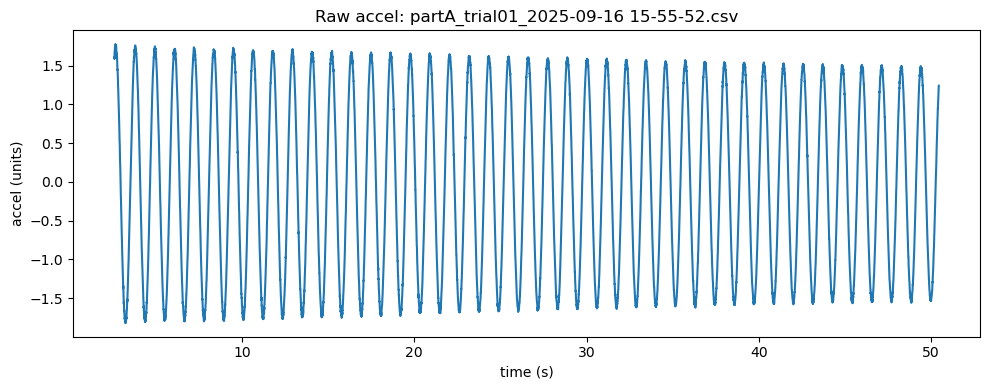

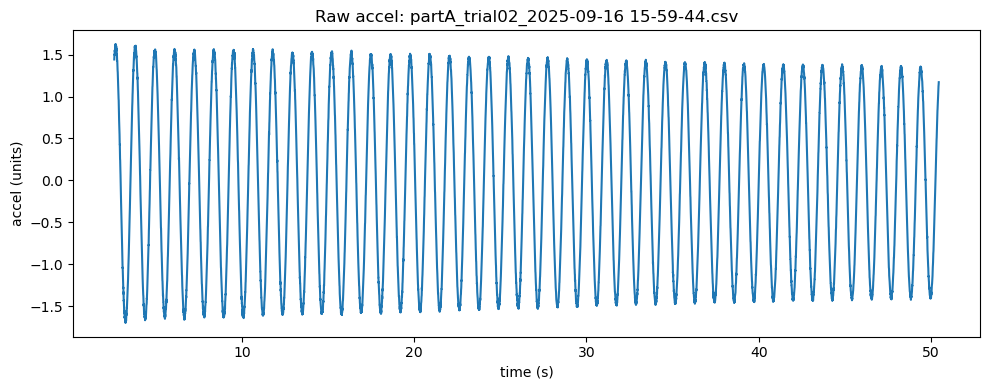

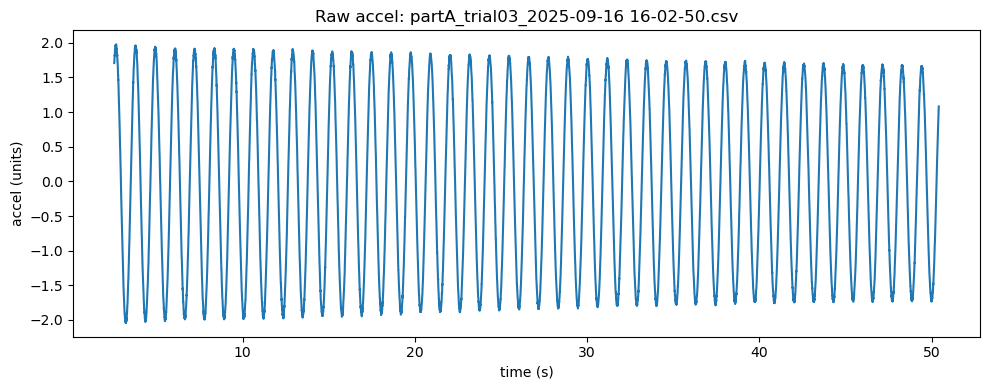

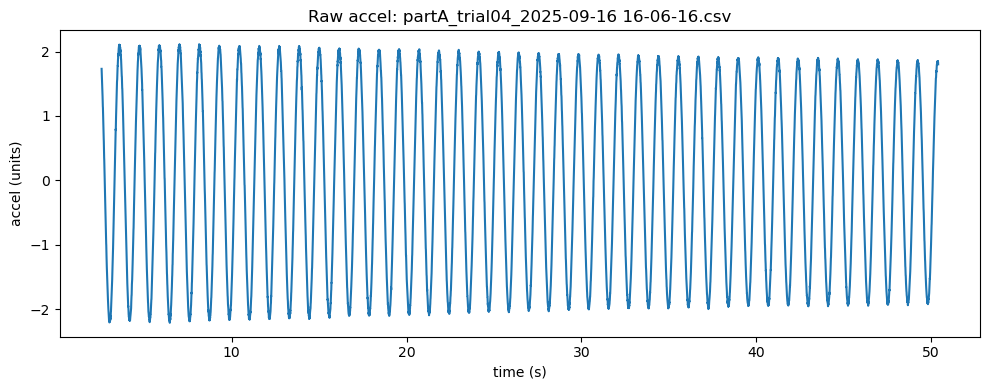

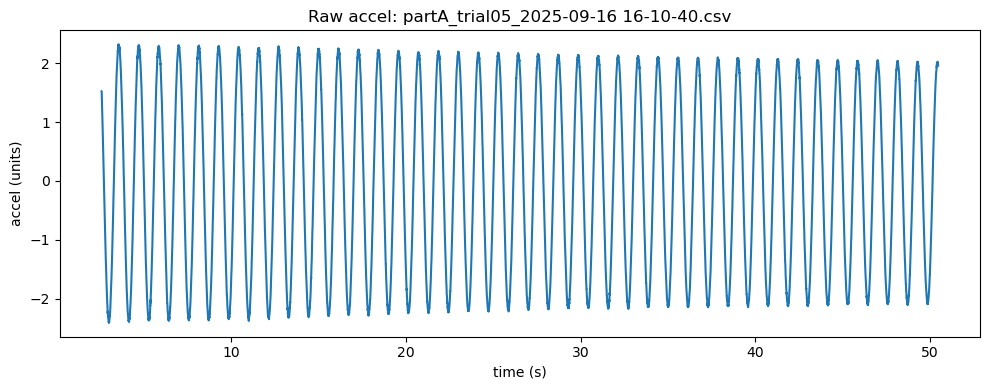

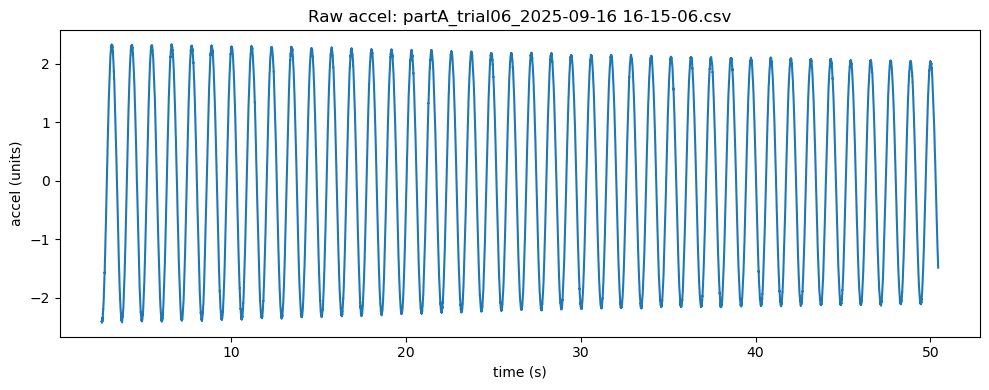

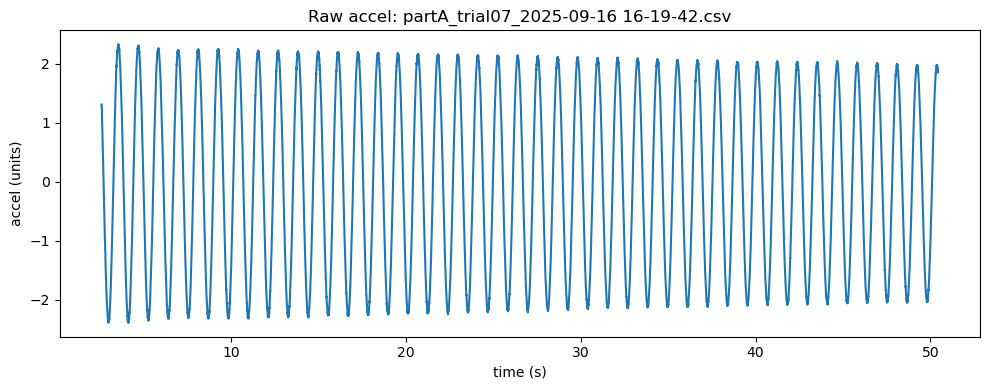

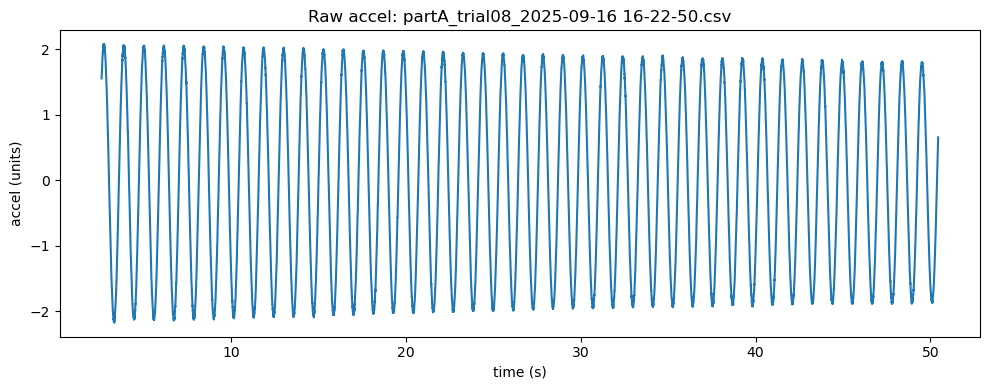

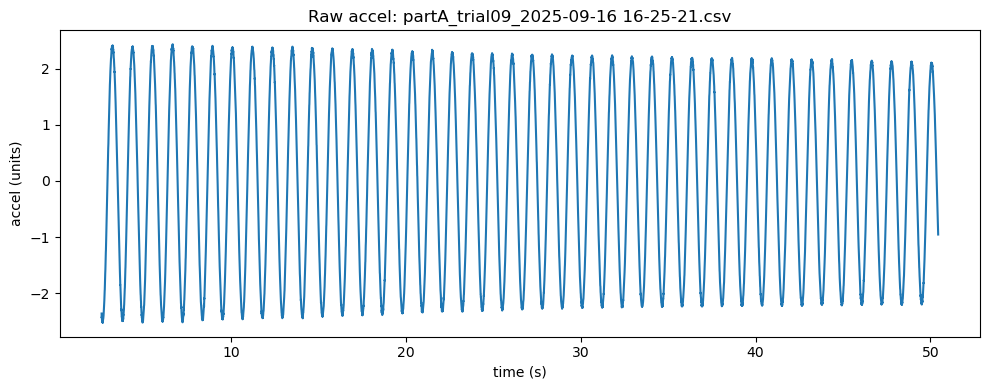

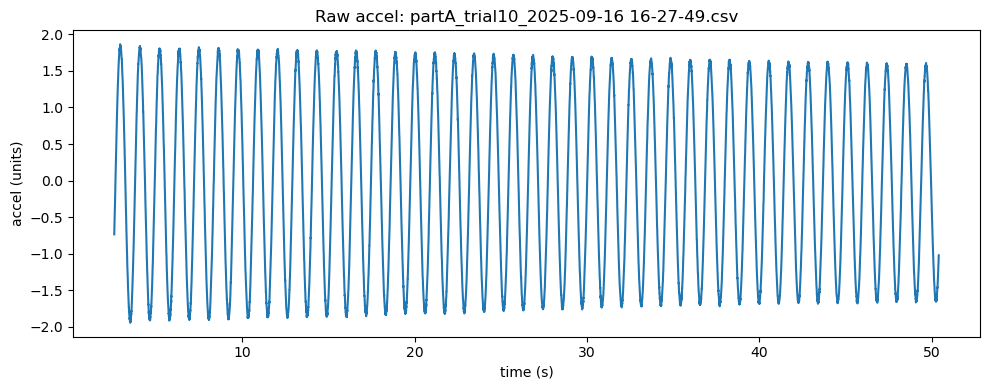

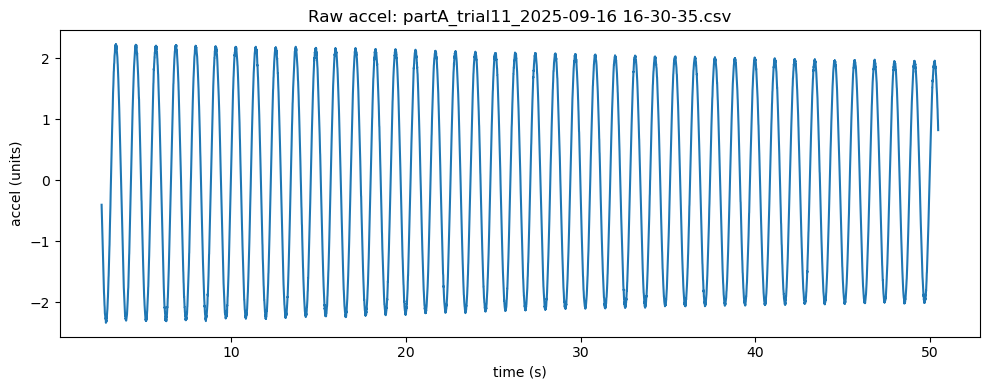

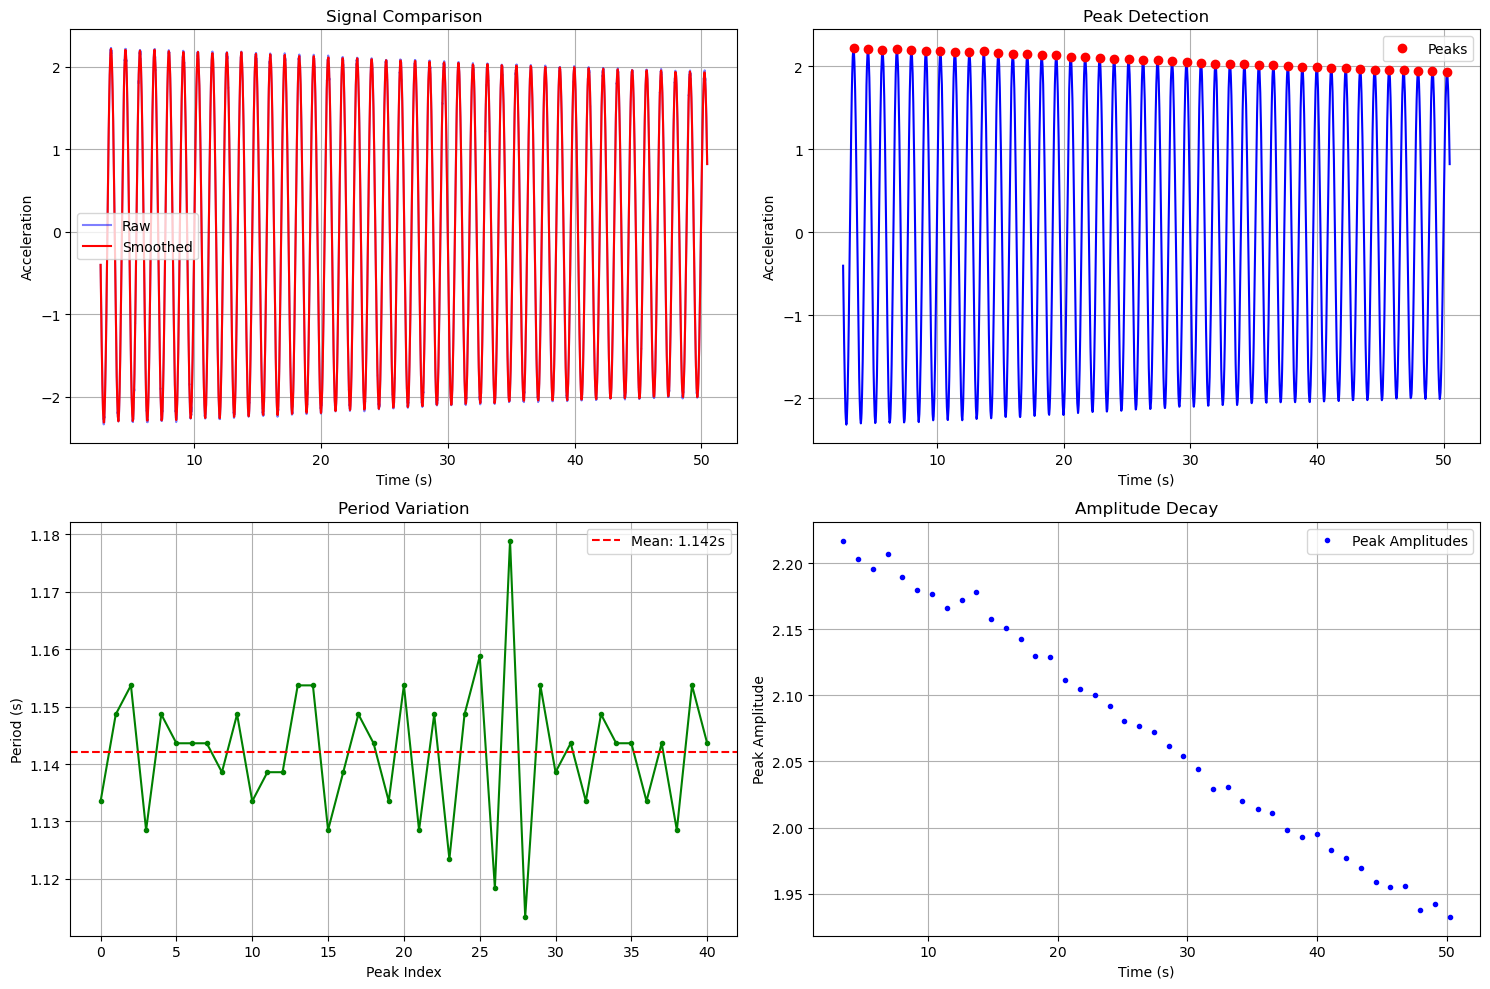

In [60]:
# Create subplots for comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Raw vs Smoothed Signal
ax1.plot(t, x, 'b-', alpha=0.5, label='Raw')
ax1.plot(t, x_smooth, 'r-', label='Smoothed')
ax1.set_title('Signal Comparison')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Acceleration')
ax1.grid(True)
ax1.legend()

# Plot 2: Peak Detection
ax2.plot(t, x_smooth, 'b-')
if len(peaks) > 0:
    ax2.plot(t[peaks], x_smooth[peaks], 'ro', label='Peaks')
ax2.set_title('Peak Detection')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Acceleration')
ax2.grid(True)
ax2.legend()

# Plot 3: Period Analysis
if isinstance(periods, np.ndarray) and len(periods) > 0:
    ax3.plot(periods, 'g.-')
    ax3.axhline(y=np.mean(periods), color='r', linestyle='--', 
                label=f'Mean: {np.mean(periods):.3f}s')
    ax3.set_title('Period Variation')
    ax3.set_xlabel('Peak Index')
    ax3.set_ylabel('Period (s)')
    ax3.grid(True)
    ax3.legend()

# Plot 4: Peak Amplitude Decay
if len(peak_times) > 0:
    ax4.plot(peak_times, peak_amps, 'b.', label='Peak Amplitudes')
    ax4.set_title('Amplitude Decay')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Peak Amplitude')
    ax4.grid(True)
    ax4.legend()

plt.tight_layout()
plt.show()

## Part B — Long Pendulum (L ≈ 1.0 m)

Repeat analysis from Part A for `partB_trialXX.csv` files. Adjust `L_long` below if your measured length differs.

In [55]:
L_long = 1.0
file_pattern = os.path.join(DATA_DIR, 'partB_trial*.csv')
files = sorted(glob.glob(file_pattern))
# Copy-paste the same loop for Part B (or refactor into a function). For brevity we reuse code:
results_B = []
for fpath in files:
    df = load_trial_csv(fpath)
    t = df['time'].values
    x = df['accel'].values
    x_smooth = signal.savgol_filter(x, 11, 3)
    periods, peaks = estimate_period_via_peaks(t, x_smooth, prominence=np.std(x_smooth)*0.5)
    if isinstance(periods, np.ndarray):
        mean_period = np.mean(periods)
        std_period = np.std(periods, ddof=1)
    else:
        mean_period = np.nan
        std_period = np.nan
    peak_times = t[peaks] if len(peaks)>0 else np.array([])
    peak_amps = np.abs(x_smooth[peaks]) if len(peaks)>0 else np.array([])
    decay = fit_exponential_decay(peak_times, peak_amps, Tn=mean_period)
    desc = compute_descriptors(x)
    result = {
        'file': os.path.basename(fpath),
        'mean_period': mean_period,
        'std_period': std_period,
        'A0': decay['A0'],
        'k': decay['k'],
        'zeta': decay['zeta'],
        **desc
    }
    results_B.append(result)
pd.DataFrame(results_B)


,file,mean_period,std_period,A0,k,zeta,mean,variance,rms,skewness,kurtosis
0,partB_trial01_2025-09-16 17-05-44.csv,1.174284,0.015819,6.929547,0.006262,0.001170,0.520724,16.704146,4.119974,-0.190196,1.585706
1,partB_trial02_2025-09-16 17-07-57.csv,1.168947,0.021292,7.026979,0.008157,0.001518,0.628787,13.413804,3.715978,-0.215970,1.817698
2,partB_trial03_2025-09-16 17-10-47.csv,1.174105,0.015699,7.292935,0.005281,0.000987,0.355521,17.573743,4.207046,-0.109017,1.585749
3,partB_trial04_2025-09-16 17-13-57.csv,1.175071,0.016235,7.404957,0.005286,0.000989,0.367309,18.069410,4.266544,-0.109954,1.582905
4,partB_trial05_2025-09-16 17-16-40.csv,1.171369,0.016697,6.967877,0.006073,0.001132,0.496943,15.224755,3.933310,-0.172561,1.653988
5,partB_trial06_2025-09-16 17-19-05.csv,1.170330,0.019620,7.060912,0.008035,0.001497,0.629669,13.597009,3.740694,-0.218844,1.801961
6,partB_trial07_2025-09-16 17-21-16.csv,1.169735,0.017954,6.975590,0.007881,0.001467,0.613245,13.515207,3.727007,-0.219843,1.803161
7,partB_trial08_2025-09-16 17-24-26.csv,1.170775,0.016956,6.942613,0.005998,0.001118,0.473203,15.186927,3.925566,-0.169452,1.651625
8,partB_trial09_2025-09-16 17-26-47.csv,1.171019,0.022237,7.300789,0.008618,0.001606,0.681441,13.977100,3.800098,-0.217180,1.846176
9,partB_trial10_2025-09-16 17-29-18.csv,1.169788,0.021311,7.120749,0.008424,0.001568,0.636997,13.425207,3.718909,-0.227736,1.827222


## Part C — Nonlinear Regime (Large Angles)

Use `partC_trialXX.csv`. For large angle trials (θ0 > 45°), measure period variation vs amplitude and compare with small-angle theory.

In [56]:
file_pattern = os.path.join(DATA_DIR, 'partC_trial*.csv')
files = sorted(glob.glob(file_pattern))
period_vs_amp = []
for fpath in files:
    df = load_trial_csv(fpath)
    t = df['time'].values
    x = df['accel'].values
    x_smooth = signal.savgol_filter(x, 11, 3)
    periods, peaks = estimate_period_via_peaks(t, x_smooth, prominence=np.std(x_smooth)*0.5)
    peak_times = t[peaks] if len(peaks)>0 else np.array([])
    peak_amps = np.abs(x_smooth[peaks]) if len(peaks)>0 else np.array([])
    if len(peak_amps)>0 and isinstance(periods, np.ndarray):
        period_vs_amp.append({'file': os.path.basename(fpath), 'mean_period': np.mean(periods), 'mean_amp': np.mean(peak_amps)})
pd.DataFrame(period_vs_amp)


,file,mean_period,mean_amp
0,partC_trial01_2025-09-16 11-45-11.csv,1.981125,1.303243
1,partC_trial02_2025-09-16 11-47-53.csv,2.308550,0.563841
2,partC_trial03_2025-09-16 15-19-13.csv,1.981827,1.549763
3,partC_trial04_2025-09-16 15-22-33.csv,1.981157,1.542396
4,partC_trial05_2025-09-16 15-24-26.csv,1.982929,1.557106
5,partC_trial06_2025-09-16 15-25-01.csv,1.982929,1.557106
6,partC_trial07_2025-09-16 15-26-52.csv,1.981186,1.476376
7,partC_trial08_2025-09-16 15-29-56.csv,1.981634,1.421238
8,partC_trial09_2025-09-16 15-31-56.csv,1.980465,1.311236
9,partC_trial10_2025-09-16 15-34-03.csv,1.982633,1.459555


## Part D — Noise Discussion

Visually inspect signals and write your qualitative assessment here. Use the examples shown in previous plots. Answer: What are possible noise sources? How do they affect period/damping estimation?

## Submission Checklist

- [ ] Export this notebook to PDF: `HW1_{STUDENT_ID}.pdf` (max 20 A4 pages)
- [ ] Create ZIP named `HW1_{STUDENT_ID}.zip` containing:
  - Executed `.ipynb`
  - `Data/` folder with CSVs
  - `Figures/` folder with generated plots
- [ ] Verify all tables are rendered as DataFrames (no screenshots)
- [ ] Confirm all equations and figures are numbered and captioned
- [ ] Ensure reproducibility: all code cells run from top to bottom without manual path edits (except `STUDENT_ID`)

**Good luck!**

In [57]:
# Helper: save summary tables and figures
summary_csv = os.path.join(BASE_DIR, f'summary_{STUDENT_ID}.csv')
if 'results_df' in globals():
    results_df.to_csv(os.path.join(BASE_DIR, 'summary_partA.csv'), index=False)
if 'results_B' in globals():
    pd.DataFrame(results_B).to_csv(os.path.join(BASE_DIR, 'summary_partB.csv'), index=False)
print('Saved summary CSVs to', BASE_DIR)


Saved summary CSVs to .
